# Libs

In [1]:
import pandas as pd
import numpy as np

In [2]:
from pandas.tseries.holiday import USFederalHolidayCalendar, Holiday
from pandas import Timestamp

In [3]:
from workalendar.usa import UnitedStates

In [4]:
from tqdm import tqdm

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [6]:
import cpi

In [7]:
from geopy.distance import geodesic

In [8]:
tqdm.pandas()

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
from catboost import CatBoostRegressor

In [11]:
from sklearn.cluster import KMeans

# Data preprocessing

In [12]:
data = pd.read_csv(r'data/train.csv')
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [142]:
df = data.copy().sample(5000000)

In [143]:
df = df[
    (df['pickup_longitude'] < -70) & (df['pickup_longitude'] > -75) & 
    (df['pickup_latitude'] < 42) & (df['pickup_latitude'] > 40) &
    (df['dropoff_longitude'] < -70) & (df['dropoff_longitude'] > -75) & 
    (df['dropoff_latitude'] < 42) & (df['dropoff_latitude'] > 40)
     ]

In [144]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
20928345,2013-05-02 14:46:00.000000185,8.0,2013-05-02 14:46:00 UTC,-73.968960,40.751597,-73.975085,40.760722,6
47679076,2015-03-12 00:17:29.0000001,5.0,2015-03-12 00:17:29 UTC,-73.984192,40.761333,-73.989738,40.756947,1
46308407,2010-11-06 00:50:00.000000269,9.3,2010-11-06 00:50:00 UTC,-73.987448,40.761955,-73.953303,40.779970,3
49156112,2012-10-30 21:37:00.00000076,4.0,2012-10-30 21:37:00 UTC,-73.976463,40.780542,-73.981880,40.774612,1
40456540,2011-09-20 11:34:29.0000001,18.9,2011-09-20 11:34:29 UTC,-73.990269,40.755914,-74.004347,40.705988,2


## date preprocessing

In [145]:
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2009-01-01', end='2016-01-01')
holidays = list(holidays.date)

years = range(2009, 2016)
weekends = []

for year in years:
    start_date = pd.Timestamp(f'{year}-01-01')
    end_date = pd.Timestamp(f'{year}-12-31')
    all_dates = pd.date_range(start=start_date, end=end_date)

    weekends.extend([date.date() for date in all_dates if date.weekday() >= 5])

In [146]:
center = (40.7, -73.8)

In [147]:
years = [i for i in range(2009, 2016)]
inflation = dict.fromkeys(years, 0)

for key in inflation.keys():
    inflation[key] = round(cpi.inflate(1000, key, to=2009) / 1000, 3)

## coordinates preprocessing

### clustering

In [148]:
coords = df[['pickup_latitude', 'pickup_longitude']]
kmeans_pick = KMeans(n_clusters=10, random_state=0).fit(coords)

In [149]:
coords = df[['dropoff_latitude', 'dropoff_longitude']]
kmeans_drop = KMeans(n_clusters=10, random_state=0).fit(coords)

### water points removing

In [150]:
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])

In [151]:
BB = (-74.5, -72.8, 40.5, 41.8)

In [152]:
df = df[select_within_boundingbox(df, BB)]

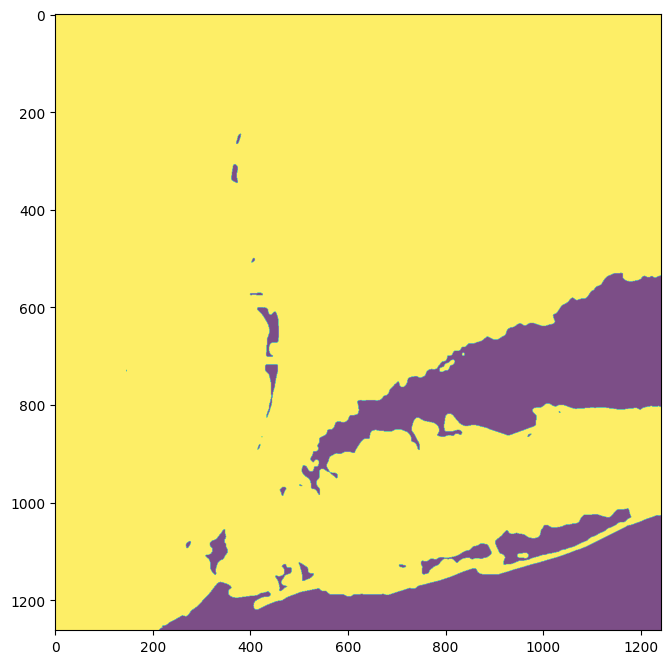

In [153]:
nyc_mask = plt.imread('nyc_map.png')[:,:,0] > 0.9

plt.figure(figsize=(8,8))
plt.imshow(nyc_mask, zorder=1, alpha=0.7)

In [154]:
def lonlat_to_xy(longitude, latitude, dx, dy, BB):
    return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
           (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

In [155]:
pickup_x, pickup_y = lonlat_to_xy(df.pickup_longitude, df.pickup_latitude, 
                                  nyc_mask.shape[1], nyc_mask.shape[0], BB)
dropoff_x, dropoff_y = lonlat_to_xy(df.dropoff_longitude, df.dropoff_latitude, 
                                  nyc_mask.shape[1], nyc_mask.shape[0], BB)

In [156]:
idx = (nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x])
print("Number of trips in water: {}".format(np.sum(~idx)))

Number of trips in water: 1031


In [157]:
def remove_datapoints_from_water(df):
    def lonlat_to_xy(longitude, latitude, dx, dy, BB):
        return (dx * (longitude - BB[0]) / (BB[1]-BB[0])).astype('int'), \
               (dy - dy * (latitude - BB[2]) / (BB[3]-BB[2])).astype('int')

    BB = (-74.5, -72.8, 40.5, 41.8)
    
    
    pickup_x, pickup_y = lonlat_to_xy(df.pickup_longitude, df.pickup_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)
    dropoff_x, dropoff_y = lonlat_to_xy(df.dropoff_longitude, df.dropoff_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)    
    idx = nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x]
    
    return df[idx]

## common preprocessing

In [158]:
def preprocess(df, is_train=True):
    df = df.dropna()

    if is_train:
        df = df[df.fare_amount.between(0, 60)]
        
        df = df[(df['passenger_count'] >= 0) & (df['passenger_count'] <= 6)]

        df = remove_datapoints_from_water(df)

    df['distance'] = df.progress_apply(lambda x: geodesic((x['pickup_latitude'], 
                                                       x['pickup_longitude']), (x['dropoff_latitude'], x['dropoff_longitude'])).km, axis=1)
    df['pick_up_distance_from_center'] = df.progress_apply(lambda x: geodesic((x['pickup_latitude'], 
                                                       x['pickup_longitude']), (center)).km, axis=1)
    df['drop_off_distance_from_center'] = df.progress_apply(lambda x: geodesic((x['dropoff_latitude'], 
                                                       x['dropoff_longitude']), (center)).km, axis=1)
    
    df['latitude_abs'] = (df.pickup_latitude - df.dropoff_latitude).abs()
    df['longitude_abs'] = (df.pickup_longitude - df.dropoff_longitude).abs()

    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

    df['is_weekend'] = df['pickup_datetime'].progress_apply(lambda x: x.date() in weekends)
    df['is_holiday'] = df['pickup_datetime'].progress_apply(lambda x: True if x.date() in holidays else False)

    df['year'] = df.pickup_datetime.dt.year.astype('uint16')
    df['month'] = df.pickup_datetime.dt.month.astype('uint8')
    df['day'] = df.pickup_datetime.dt.day.astype('uint8')
    df['dayofweek'] = df.pickup_datetime.dt.dayofweek.astype('uint8')

    df['sin_dayofweek'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)

    df['hour'] = df['pickup_datetime'].progress_apply(lambda x: np.sin(2 * np.pi * x.hour / 24))
    df['is_rush_hour'] = df['pickup_datetime'].dt.hour.between(8, 9) | df['pickup_datetime'].dt.hour.between(16, 19)
    df['pickup_cluster'] = kmeans_pick.predict(df[['pickup_latitude', 'pickup_longitude']])
    df['dropoff_cluster'] = kmeans_drop.predict(df[['dropoff_latitude', 'dropoff_longitude']])

    if is_train:
        df['fare_amount_adjusted'] = df.progress_apply(lambda x: inflation[x['pickup_datetime'].year] * x['fare_amount'], axis=1)
    return df

In [159]:
df.fare_amount.max()

61550.86

In [160]:
df = preprocess(df)

100%|██████████| 4880600/4880600 [00:30<00:00, 159227.66it/s]


In [161]:
df['sin_dayofweek'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)

In [162]:
df.to_csv('df.csv', index=False)

In [163]:
df.isnull().sum()

key                              0
fare_amount                      0
pickup_datetime                  0
pickup_longitude                 0
pickup_latitude                  0
dropoff_longitude                0
dropoff_latitude                 0
passenger_count                  0
distance                         0
pick_up_distance_from_center     0
drop_off_distance_from_center    0
latitude_abs                     0
longitude_abs                    0
is_weekend                       0
is_holiday                       0
year                             0
month                            0
day                              0
dayofweek                        0
sin_dayofweek                    0
sin_month                        0
hour                             0
is_rush_hour                     0
pickup_cluster                   0
dropoff_cluster                  0
fare_amount_adjusted             0
dtype: int64

# графики

<Figure size 1000x1000 with 0 Axes>

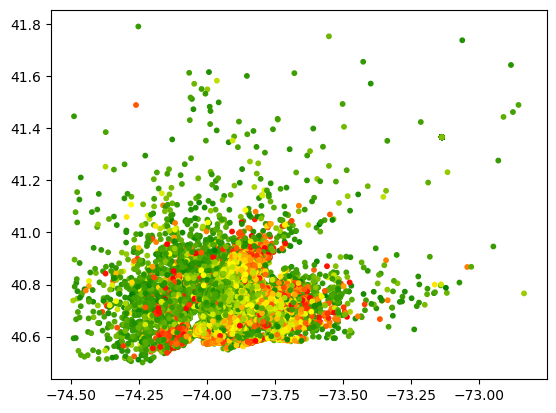

In [164]:
from matplotlib.colors import Normalize


plt.figure(figsize=(10, 10))


quantiles = np.percentile(df['fare_amount'], [0, 25, 50, 75, 100])

# Нормализация с использованием квантилей
norm = Normalize(vmin=quantiles[0], vmax=quantiles[-1])

# Цветовая карта
cmap = plt.get_cmap('RdYlGn')


cmap = LinearSegmentedColormap.from_list(name='name', colors=['green','yellow','red'])
f, ax = plt.subplots()
points = ax.scatter(df['dropoff_longitude'], df['dropoff_latitude'], c=df['fare_amount'],
                    s=10, cmap=cmap, norm=norm)

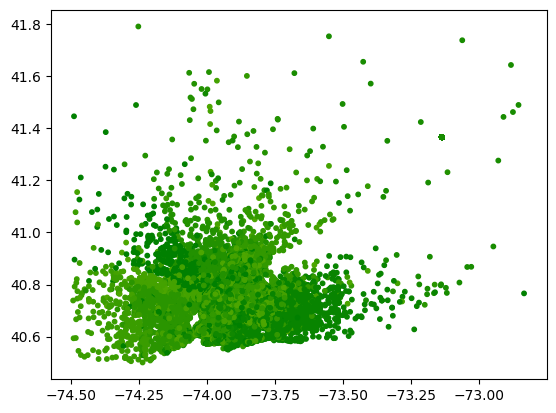

In [165]:
cmap = LinearSegmentedColormap.from_list(name='name', colors=['green','yellow','red'])
f, ax = plt.subplots()
points = ax.scatter(df['dropoff_longitude'], df['dropoff_latitude'], c=df['pickup_cluster'],
                    s=10, cmap=cmap, norm=norm)

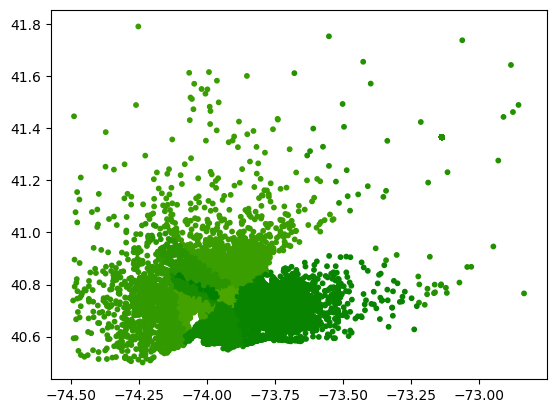

In [166]:
cmap = LinearSegmentedColormap.from_list(name='name', colors=['green','yellow','red'])
f, ax = plt.subplots()
points = ax.scatter(df['dropoff_longitude'], df['dropoff_latitude'], c=df['dropoff_cluster'],
                    s=10, cmap=cmap, norm=norm)

<Axes: >

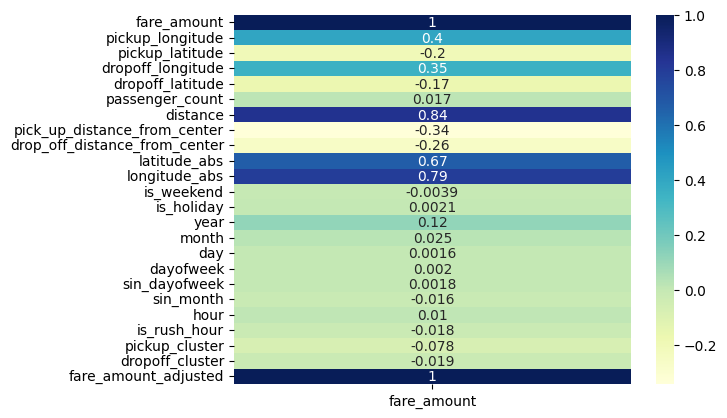

In [167]:
sns.heatmap(df.corr(numeric_only=True)[['fare_amount']], cmap="YlGnBu", annot=True)

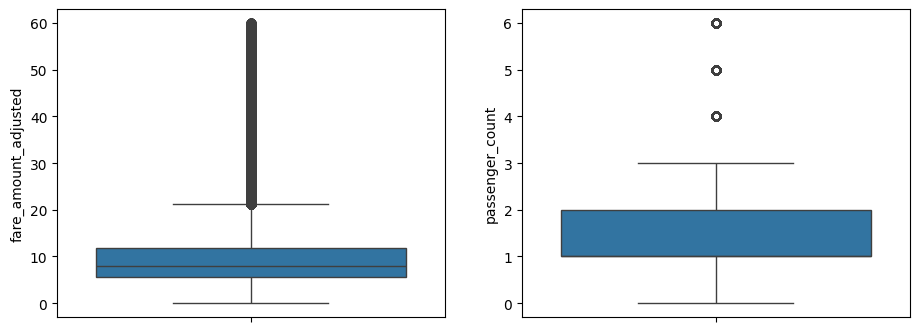

In [168]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 4))


sns.boxplot(df['fare_amount_adjusted'], ax=axes[0])
sns.boxplot(df['passenger_count'], ax=axes[1])
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_13948\869878874.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(x="hour2", y="fare_amount", kind="bar", palette=palette, data=hourly_fares, height=8, aspect=1.5)
C:\Users\User\AppData\Local\Temp\ipykernel_13948\869878874.py:8: UserWarning: 
The palette list has fewer values (10) than needed (24) and will cycle, which may produce an uninterpretable plot.
  sns.catplot(x="hour2", y="fare_amount", kind="bar", palette=palette, data=hourly_fares, height=8, aspect=1.5)


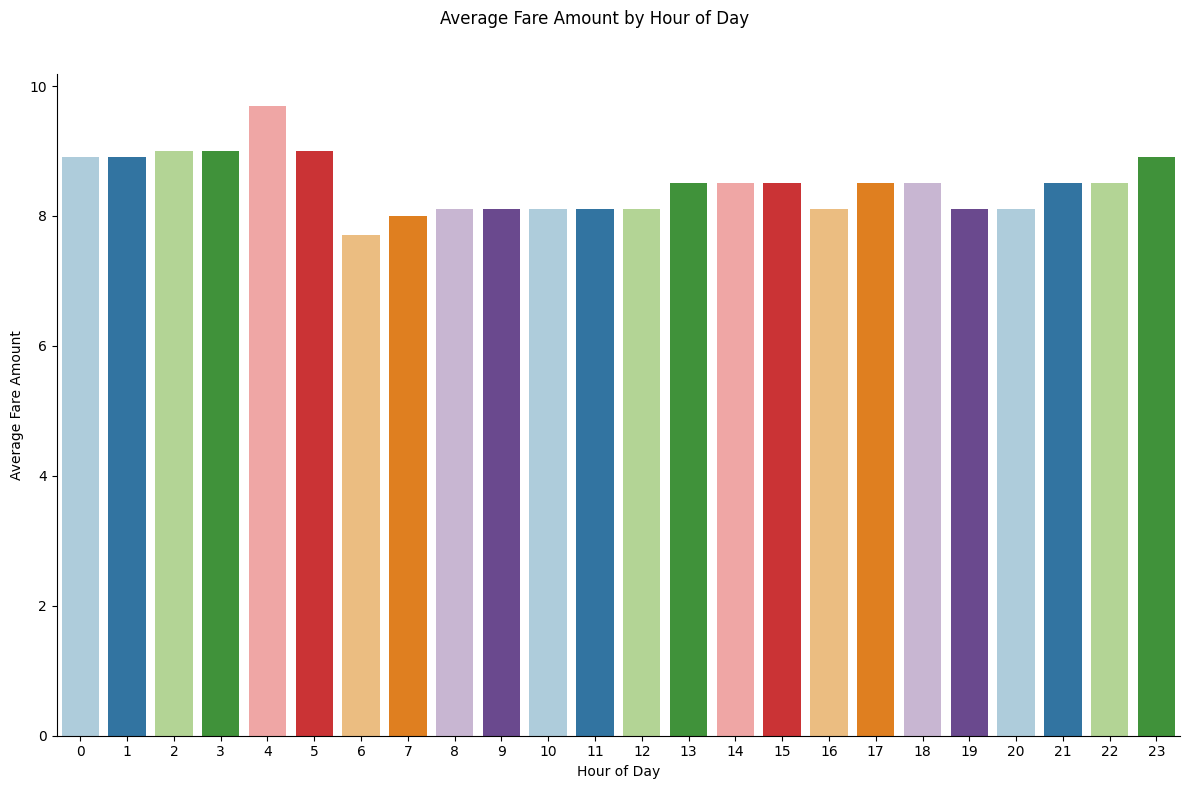

In [169]:
palette = sns.color_palette('Paired', 10)

# Создаем новый датафрейм со средней стоимостью поездки по каждому часу
df['hour2'] = df.pickup_datetime.dt.hour.astype('uint16')
hourly_fares = df.groupby('hour2', as_index=False).agg({'fare_amount': 'median'})

# Построение графика
sns.catplot(x="hour2", y="fare_amount", kind="bar", palette=palette, data=hourly_fares, height=8, aspect=1.5)
sns.despine()

# Установка заголовка и подписей осей
plt.subplots_adjust(top=0.9)  # Оставляем место для заголовка
plt.suptitle('Average Fare Amount by Hour of Day')  # Заголовок всего графика
plt.xlabel("Hour of Day")
plt.ylabel("Average Fare Amount")

plt.show()
df = df.drop(columns=['hour2'])

# fitting

In [ ]:
to_drop = ['key', 'fare_amount', 'fare_amount_adjusted', 'pickup_datetime']

X = df.drop(to_drop, axis=1)
y = df['fare_amount_adjusted']

In [213]:
X.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,pick_up_distance_from_center,drop_off_distance_from_center,latitude_abs,longitude_abs,is_weekend,is_holiday,year,month,day,dayofweek,sin_dayofweek,sin_month,hour,is_rush_hour
20928345,-73.968960,40.751597,-73.975085,40.760722,6,1.137693,15.381282,16.255257,0.009125,0.006125,False,False,2013,5,2,3,0.433884,0.500000,-0.500000,False
47679076,-73.984192,40.761333,-73.989738,40.756947,1,0.675784,16.985318,17.231368,0.004387,0.005547,False,False,2015,3,12,3,0.433884,1.000000,0.000000,False
46308407,-73.987448,40.761955,-73.953303,40.779970,3,3.508887,17.264973,15.701407,0.018015,0.034145,True,False,2010,11,6,5,-0.974928,-0.500000,0.000000,False
49156112,-73.976463,40.780542,-73.981880,40.774612,1,0.801728,17.382521,17.454955,0.005930,0.005417,False,False,2012,10,30,1,0.781831,-0.866025,-0.707107,False
40456540,-73.990269,40.755914,-74.004347,40.705988,2,5.670334,17.231534,17.282510,0.049926,0.014078,False,False,2011,9,20,1,0.781831,-1.000000,0.258819,False


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=2024)

# model = CatBoostRegressor(iterations=1000,
#                           depth=3,
#                           learning_rate=0.01,
#                           eval_metric='RMSE',
#                           use_best_model=True,
#                           verbose=100)

model = CatBoostRegressor(iterations=400,
                          use_best_model=True)

In [217]:
model.fit(X_train, y_train, eval_set=(X_test, y_test))

Learning rate set to 0.336784
0:	learn: 6.2407856	test: 6.2598806	best: 6.2598806 (0)	total: 223ms	remaining: 1m 29s
1:	learn: 4.9915217	test: 5.0033584	best: 5.0033584 (1)	total: 425ms	remaining: 1m 24s
2:	learn: 4.2800003	test: 4.2838137	best: 4.2838137 (2)	total: 610ms	remaining: 1m 20s
3:	learn: 3.8778292	test: 3.8729471	best: 3.8729471 (3)	total: 795ms	remaining: 1m 18s
4:	learn: 3.6539943	test: 3.6467639	best: 3.6467639 (4)	total: 965ms	remaining: 1m 16s
5:	learn: 3.5293523	test: 3.5209954	best: 3.5209954 (5)	total: 1.15s	remaining: 1m 15s
6:	learn: 3.4565070	test: 3.4490908	best: 3.4490908 (6)	total: 1.32s	remaining: 1m 14s
7:	learn: 3.4117241	test: 3.4058461	best: 3.4058461 (7)	total: 1.49s	remaining: 1m 13s
8:	learn: 3.3769079	test: 3.3704077	best: 3.3704077 (8)	total: 1.7s	remaining: 1m 13s
9:	learn: 3.3479770	test: 3.3439376	best: 3.3439376 (9)	total: 1.87s	remaining: 1m 13s
10:	learn: 3.3277145	test: 3.3252201	best: 3.3252201 (10)	total: 2.07s	remaining: 1m 13s
11:	learn: 3

In [218]:
from sklearn.metrics import root_mean_squared_error

In [219]:
len(model.predict(df[X.columns]))

4880600

In [220]:
root_mean_squared_error(np.array(df['fare_amount']), model.predict(df[X.columns]))

3.211008809237216

# Inferring

In [221]:
pd.read_csv(r'data/sample_submission.csv').head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.35
1,2015-01-27 13:08:24.0000003,11.35
2,2011-10-08 11:53:44.0000002,11.35
3,2012-12-01 21:12:12.0000002,11.35
4,2012-12-01 21:12:12.0000003,11.35


In [222]:
test = pd.read_csv(r'data/test.csv')

In [223]:
test = preprocess(test, is_train=False)

100%|██████████| 9914/9914 [00:00<00:00, 568165.52it/s]


In [224]:
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,pick_up_distance_from_center,drop_off_distance_from_center,...,year,month,day,dayofweek,sin_dayofweek,sin_month,hour,is_rush_hour,pickup_cluster,dropoff_cluster
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2.320991,16.265611,16.082996,...,2015,1,27,1,0.781831,5.000000e-01,-0.258819,False,9,3
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2.423802,15.936492,17.358727,...,2015,1,27,1,0.781831,5.000000e-01,-0.258819,False,2,3
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1,0.618182,16.437309,16.019768,...,2011,10,8,5,-0.974928,-8.660254e-01,0.258819,False,9,3
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1,1.959671,17.055285,17.080795,...,2012,12,1,5,-0.974928,-2.449294e-16,-0.707107,False,0,3
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1,5.382833,17.206476,16.677782,...,2012,12,1,5,-0.974928,-2.449294e-16,-0.707107,False,4,3


In [225]:
test[X.columns].head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,pick_up_distance_from_center,drop_off_distance_from_center,latitude_abs,longitude_abs,is_weekend,is_holiday,year,month,day,dayofweek,sin_dayofweek,sin_month,hour,is_rush_hour
0,-73.973320,40.763805,-73.981430,40.743835,1,2.320991,16.265611,16.082996,0.019970,0.008110,False,False,2015,1,27,1,0.781831,5.000000e-01,-0.258819,False
1,-73.986862,40.719383,-73.998886,40.739201,1,2.423802,15.936492,17.358727,0.019817,0.012024,False,False,2015,1,27,1,0.781831,5.000000e-01,-0.258819,False
2,-73.982524,40.751260,-73.979654,40.746139,1,0.618182,16.437309,16.019768,0.005121,0.002870,True,False,2011,10,8,5,-0.974928,-8.660254e-01,0.258819,False
3,-73.981160,40.767807,-73.990448,40.751635,1,1.959671,17.055285,17.080795,0.016172,0.009288,True,False,2012,12,1,5,-0.974928,-2.449294e-16,-0.707107,False
4,-73.966046,40.789775,-73.988565,40.744427,1,5.382833,17.206476,16.677782,0.045348,0.022519,True,False,2012,12,1,5,-0.974928,-2.449294e-16,-0.707107,False


In [226]:
test['fare_amount'] = model.predict(test[X.columns])

In [227]:
test['fare_amount'] = test.apply(lambda x: x['fare_amount'] / inflation[x['pickup_datetime'].year], axis=1)

In [228]:
test[['key', 'fare_amount']].to_csv('sub2.csv', index=False)

In [229]:
test[['key', 'fare_amount']]

,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.455014
1,2015-01-27 13:08:24.0000003,10.424071
2,2011-10-08 11:53:44.0000002,4.140956
3,2012-12-01 21:12:12.0000002,9.134347
4,2012-12-01 21:12:12.0000003,17.120522
...,...,...
9909,2015-05-10 12:37:51.0000002,8.820798
9910,2015-01-12 17:05:51.0000001,10.615478
9911,2015-04-19 20:44:15.0000001,54.320186
9912,2015-01-31 01:05:19.0000005,19.624761


In [230]:
pd.DataFrame({
    'columns': X.columns,
    'importances': model.feature_importances_}
    )

,columns,importances
0,pickup_longitude,2.480429
1,pickup_latitude,2.296351
2,dropoff_longitude,3.017826
3,dropoff_latitude,5.987941
4,passenger_count,0.103030
5,distance,50.650401
6,pick_up_distance_from_center,5.106873
7,drop_off_distance_from_center,4.847307
8,latitude_abs,2.277531
9,longitude_abs,12.711830


<Figure size 1000x1000 with 0 Axes>

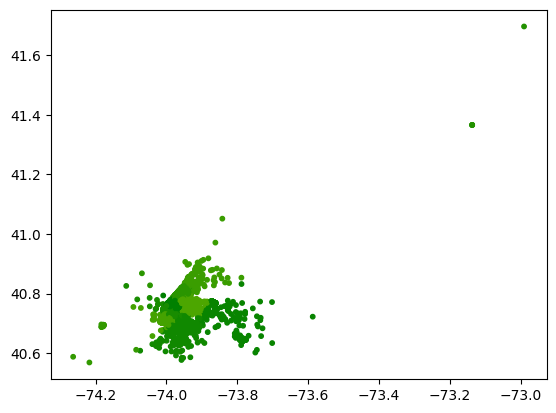

In [231]:
from matplotlib.colors import Normalize


plt.figure(figsize=(10, 10))


# quantiles = np.percentile(test['fare_amount'], [0, 25, 50, 75, 100])

# Нормализация с использованием квантилей
# norm = Normalize(vmin=quantiles[0], vmax=quantiles[-1])

# Цветовая карта
cmap = plt.get_cmap('RdYlGn')


cmap = LinearSegmentedColormap.from_list(name='name', colors=['green','yellow','red'])
f, ax = plt.subplots()
points = ax.scatter(test['dropoff_longitude'], test['dropoff_latitude'], c=test['dropoff_cluster'],
                    s=10, cmap=cmap, norm=norm)

C:\Users\User\AppData\Local\Temp\ipykernel_13948\897063285.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  points = ax.scatter(test['pickup_longitude'], test['pickup_latitude'],


<Figure size 1000x1000 with 0 Axes>

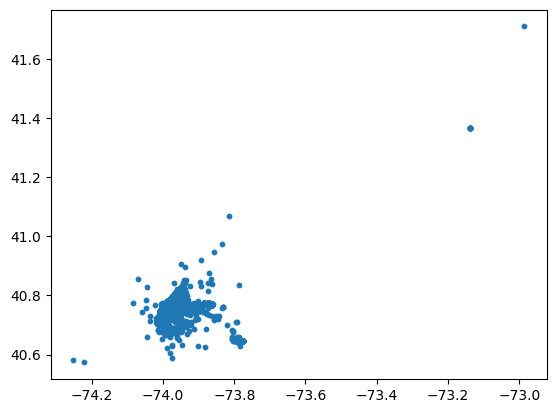

In [232]:
from matplotlib.colors import Normalize


plt.figure(figsize=(10, 10))


# quantiles = np.percentile(test['fare_amount'], [0, 25, 50, 75, 100])

# Нормализация с использованием квантилей
# norm = Normalize(vmin=quantiles[0], vmax=quantiles[-1])

# Цветовая карта
cmap = plt.get_cmap('RdYlGn')


cmap = LinearSegmentedColormap.from_list(name='name', colors=['green','yellow','red'])
f, ax = plt.subplots()
points = ax.scatter(test['pickup_longitude'], test['pickup_latitude'],
                    s=10, cmap=cmap, norm=norm)

In [233]:
data.sample(200_000).to_csv('data.csv', index=False)